# In this notebook, LSTM Univariate & Multivariate models will be explored

In [1]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
keras = tf.keras
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from sklearn.model_selection import train_test_split

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import pickle
from datetime import datetime

## LSTM

#### Reload the data

The plan:

First run only price data to do a univariate LSTM ... DONE
Check results for all data including 2020 ... Poor Results

Check results for 2019 data only ... DONE, good results
Compare one_step predictions with known data ... DONE dood results

Then do multivariate with price, offer qty and sold qty, for 1 tea category
Then add all categories

In [2]:
def get_timestamp():
    timestamp =   str(datetime.now().year) + '_'\
                + str(datetime.now().month).zfill(2) + '_'\
                + str(datetime.now().day).zfill(2) + '_'\
                + str(datetime.now().hour).zfill(2) + '_'\
                + str(datetime.now().minute).zfill(2) + '_'\
                + str(datetime.now().second).zfill(2)
    return ''

In [3]:
# load dataset
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
df_CHN_CTC_dust = pd.read_csv('../Data/df_CHN_CTC_dust.csv', header=0, index_col=0)
df_CHN_Ortho_leaf = pd.read_csv('../Data/df_CHN_Ortho_leaf.csv', header=0, index_col=0)
df_CHN_Ortho_dust = pd.read_csv('../Data/df_CHN_Ortho_dust.csv', header=0, index_col=0)

In [4]:
# chop out 2020 data
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
df_CHN_CTC_dust = df_CHN_CTC_dust[pd.to_datetime(df_CHN_CTC_dust.index) < pd.to_datetime('2020-01-01')]
df_CHN_Ortho_leaf = df_CHN_Ortho_leaf[pd.to_datetime(df_CHN_Ortho_leaf.index) < pd.to_datetime('2020-01-01')]
df_CHN_Ortho_dust = df_CHN_Ortho_dust[pd.to_datetime(df_CHN_Ortho_dust.index) < pd.to_datetime('2020-01-01')]

In [5]:
def plot_oqty_sqty_avgp(df, category, city):

    fig, axs = plt.subplots(3, figsize=(15, 10))

    axs[0].plot(pd.to_datetime(df.index), df[category + '_offer_qty'],'*-', c='r',
                label=category.upper() + ' Offer Qty')
    axs[0].set_title(category.upper() + ' Offer Qty - ' + city)
    axs[0].set_ylabel('Kgs')
    axs[0].legend(loc='best')
    axs[0].tick_params(rotation=75, axis='x')
                            
    axs[1].plot(pd.to_datetime(df.index), df[category + '_sold_qty'], '*-', c='g',
                label=category.upper() + ' Sold Qty')
    axs[1].set_title(category.upper() + ' Sold Qty - ' + city)
    axs[1].set_ylabel('Kgs')
    axs[1].legend(loc='best')
    axs[1].tick_params(rotation=75, axis='x')
                            
    axs[2].plot(pd.to_datetime(df.index), df[category + '_avg_price'],'*-', c='b',
                label=category.upper() + ' Avg Price')
    axs[2].set_title(category.upper() + ' Avg Price - ' + city)
    axs[2].set_ylabel('Rs. per Kg')
    axs[2].legend(loc='best')
    axs[2].tick_params(rotation=75, axis='x')


    fig.tight_layout()
    fig.savefig('../Images/' + category.upper() + '_' + city + '_oqty_sqty_avgp' + get_timestamp())
                        
                        
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

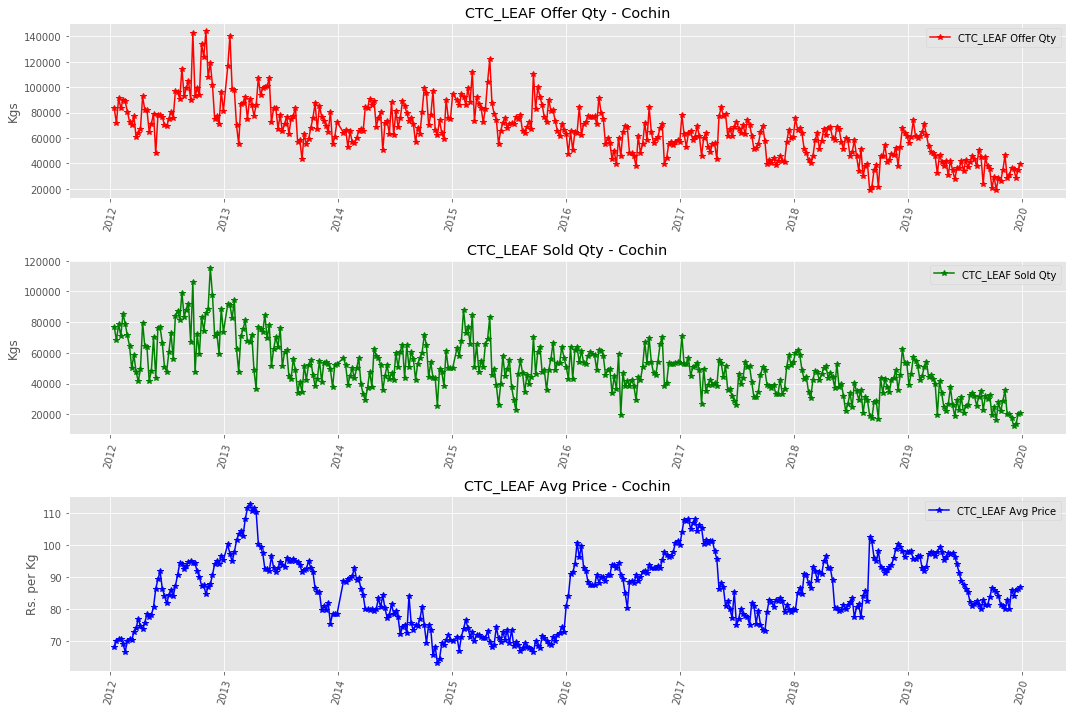

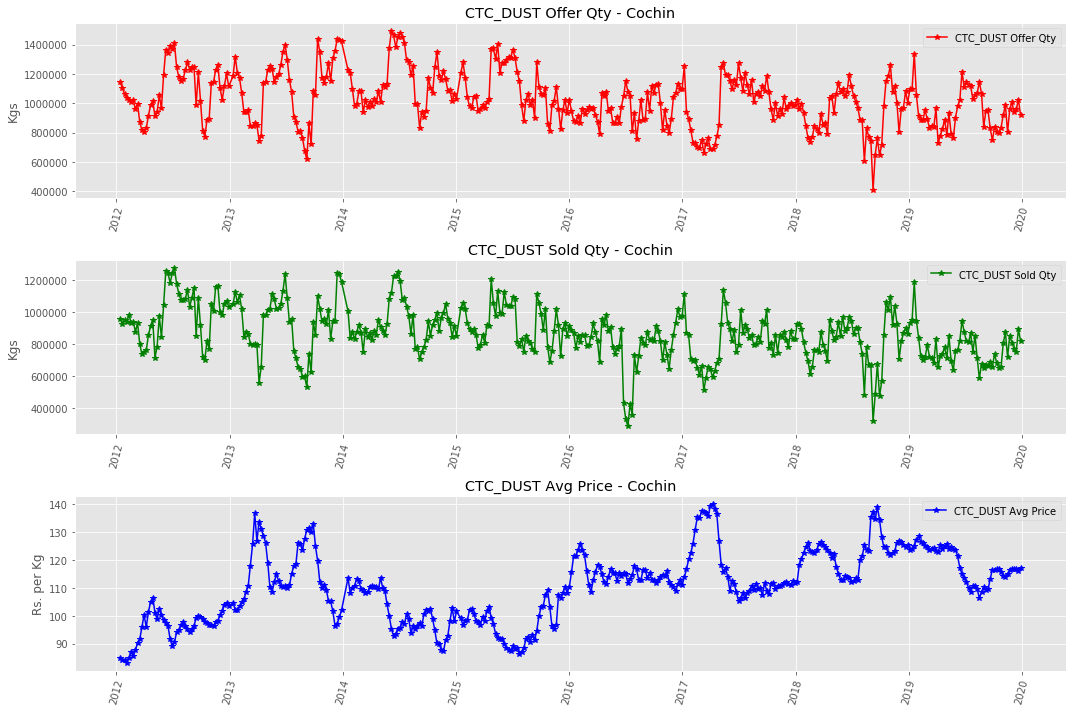

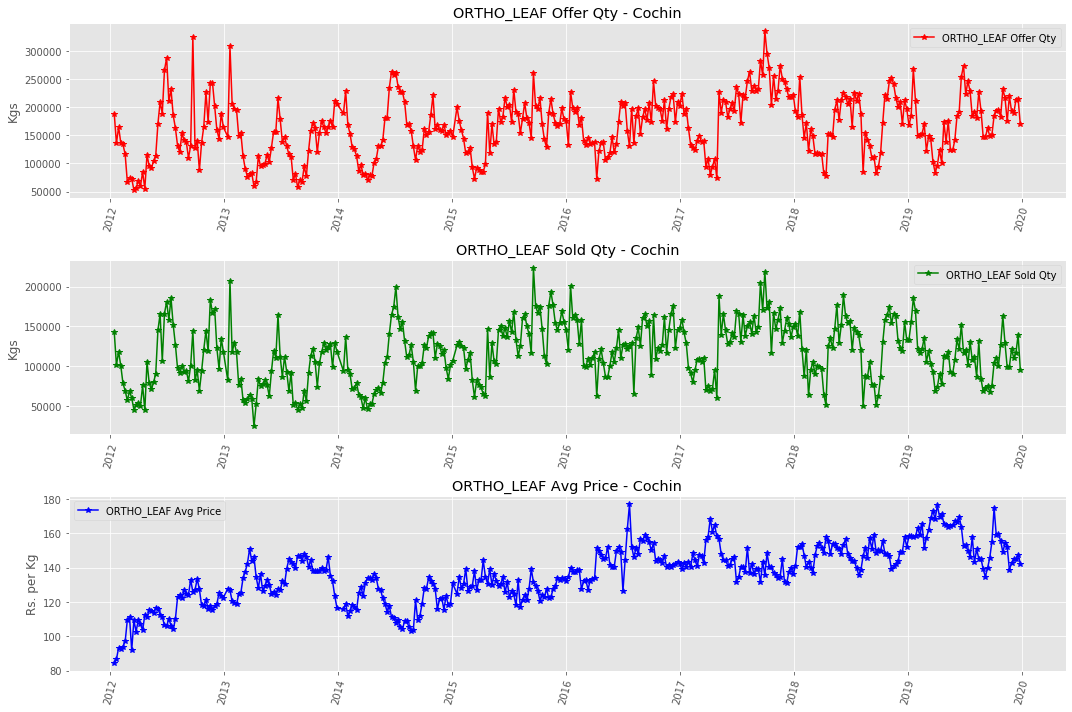

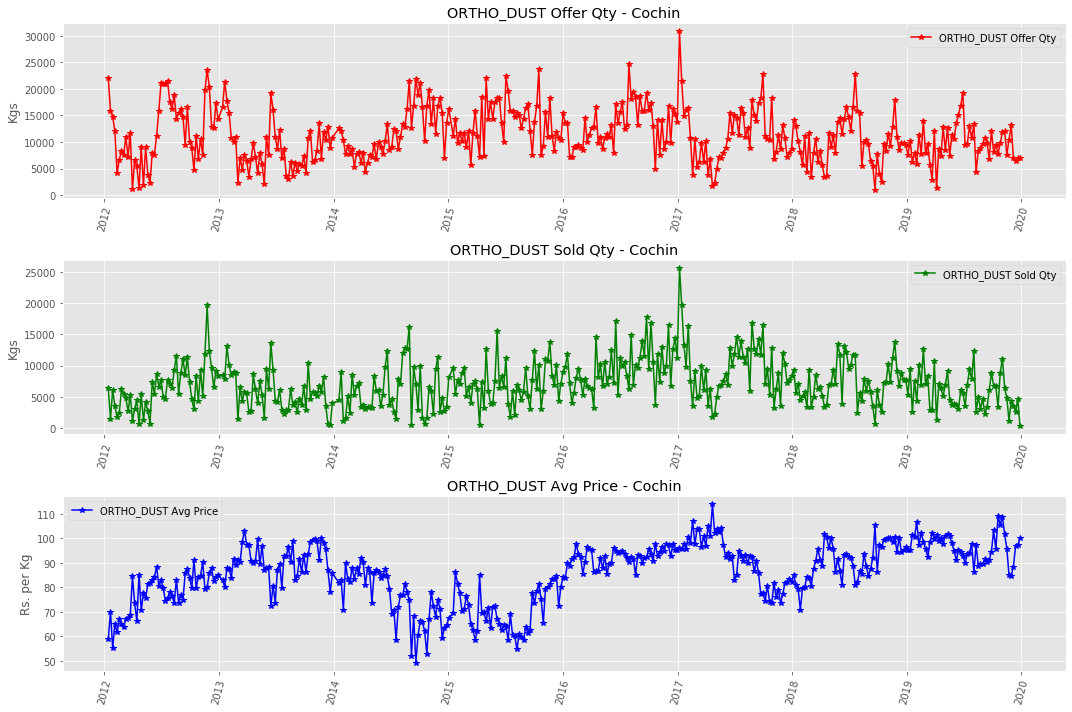

In [6]:
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_CTC_dust, 'ctc_dust', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_leaf, 'ortho_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_dust, 'ortho_dust', 'Cochin')

## Univariate (Price only)

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First, a function to consider every possible group of n_prev values followed by one value (for the output) along the time-series data.

In [7]:
# Set up the first price series
price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = price_series.index #pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
# price_series.index = time_series
time_series

Index(['14-Jan-12', '21-Jan-12', '28-Jan-12', '4-Feb-12', '11-Feb-12',
       '18-Feb-12', '25-Feb-12', '3-Mar-12', '10-Mar-12', '17-Mar-12',
       ...
       '26-Oct-19', '2-Nov-19', '9-Nov-19', '16-Nov-19', '23-Nov-19',
       '30-Nov-19', '7-Dec-19', '14-Dec-19', '21-Dec-19', '28-Dec-19'],
      dtype='object', name='week_ending', length=412)

In [8]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [9]:
def split_and_windowize(data, n_prev, fraction_test=0.05):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [10]:
df_CHN_CTC_leaf

,year,serial_no,ctc_leaf_offer_qty,ctc_leaf_sold_qty,ctc_leaf_avg_price
week_ending,,,,,
14-Jan-12,2012,2,83325.0,77015.0,68.03
21-Jan-12,2012,3,71897.0,68187.0,70.11
28-Jan-12,2012,4,91279.0,78695.0,70.73
4-Feb-12,2012,5,83746.0,71188.0,70.63
11-Feb-12,2012,6,89650.0,85480.0,69.23
...,...,...,...,...,...
30-Nov-19,2019,48,36457.0,17801.0,86.08
7-Dec-19,2019,49,35657.0,12185.0,84.15
14-Dec-19,2019,50,28768.0,13576.0,85.86


In [11]:
n_prev = 10

x_train, x_test, y_train, y_test = split_and_windowize(price_series.values, n_prev)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# ((363, 10, 3), (29, 10, 3), (363, 3), (29, 3))

((363, 10, 1), (29, 10, 1), (363,), (29,))

The "vanishing gradients problem" of traditional RNNs,  where the effect of the input at the beginning exponentially shrinks with the depth of the network, makes it very hard to remember details from the signal from each successively earlier point.

Long Short Term Memory (LSTM) networks do a better job of handling long-term dependencies. [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [12]:
# LSTM_price_model = keras.Sequential()

# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [13]:
LSTM_price_model = keras.Sequential()

LSTM_price_model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))

LSTM_price_model.add(keras.layers.Dropout(0.1))

LSTM_price_model.add(keras.layers.LSTM(32, return_sequences=False))

LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

LSTM_price_model.compile(optimizer='adam', loss='mape')

In [14]:
LSTM_price_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            4352      
_________________________________________________________________
dropout (Dropout)            (None, 10, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [25]:
LSTM_price_model_history = LSTM_price_model.fit(x_train, 
                                                y_train, 
                                                validation_data=(x_test, y_test), 
                                                batch_size=10, 
                                                epochs=500)

Epoch 1/500
37/37 [==============================] - 1s 19ms/step - loss: 3.1061 - val_loss: 1.9319
Epoch 2/500
37/37 [==============================] - 0s 6ms/step - loss: 3.2916 - val_loss: 2.5971
Epoch 3/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0361 - val_loss: 2.0066
Epoch 4/500
37/37 [==============================] - 0s 6ms/step - loss: 3.2488 - val_loss: 1.9562
Epoch 5/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1079 - val_loss: 1.8710
Epoch 6/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1803 - val_loss: 1.9338
Epoch 7/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0390 - val_loss: 1.8425
Epoch 8/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0200 - val_loss: 2.2853
Epoch 9/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0130 - val_loss: 1.9112
Epoch 10/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9478 - val_loss: 2.0217
Epoch 11

37/37 [==============================] - 0s 6ms/step - loss: 3.1161 - val_loss: 2.5694
Epoch 84/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9593 - val_loss: 2.0032
Epoch 85/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0892 - val_loss: 2.3096
Epoch 86/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1510 - val_loss: 2.3254
Epoch 87/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1708 - val_loss: 1.9267
Epoch 88/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0657 - val_loss: 2.3048
Epoch 89/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0324 - val_loss: 2.2478
Epoch 90/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1080 - val_loss: 2.2463
Epoch 91/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9839 - val_loss: 2.0105
Epoch 92/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9703 - val_loss: 1.9001
Epoch 93/500


37/37 [==============================] - 0s 6ms/step - loss: 2.9870 - val_loss: 2.2046
Epoch 165/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0795 - val_loss: 2.1280
Epoch 166/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0793 - val_loss: 2.2291
Epoch 167/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0322 - val_loss: 1.8847
Epoch 168/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1723 - val_loss: 2.0998
Epoch 169/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9450 - val_loss: 2.6344
Epoch 170/500
37/37 [==============================] - 0s 6ms/step - loss: 3.2348 - val_loss: 2.2172
Epoch 171/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1330 - val_loss: 2.5654
Epoch 172/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1180 - val_loss: 3.1992
Epoch 173/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9921 - val_loss: 2.4834
Epoc

37/37 [==============================] - 0s 6ms/step - loss: 3.1393 - val_loss: 2.5456
Epoch 246/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9142 - val_loss: 2.1050
Epoch 247/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9745 - val_loss: 1.8648
Epoch 248/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1526 - val_loss: 2.3679
Epoch 249/500
37/37 [==============================] - 0s 6ms/step - loss: 2.8496 - val_loss: 2.3233
Epoch 250/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1739 - val_loss: 2.2585
Epoch 251/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9953 - val_loss: 2.0288
Epoch 252/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9035 - val_loss: 1.8627
Epoch 253/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9687 - val_loss: 2.3015
Epoch 254/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9495 - val_loss: 2.8002
Epoc

37/37 [==============================] - 0s 6ms/step - loss: 2.8964 - val_loss: 1.8661
Epoch 327/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0226 - val_loss: 3.0363
Epoch 328/500
37/37 [==============================] - 0s 6ms/step - loss: 2.8973 - val_loss: 1.8782
Epoch 329/500
37/37 [==============================] - 0s 6ms/step - loss: 2.8998 - val_loss: 2.2971
Epoch 330/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0376 - val_loss: 2.0172
Epoch 331/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0141 - val_loss: 2.5800
Epoch 332/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0549 - val_loss: 2.0594
Epoch 333/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0093 - val_loss: 1.9652
Epoch 334/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9376 - val_loss: 2.1854
Epoch 335/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9418 - val_loss: 2.0112
Epoc

37/37 [==============================] - 0s 6ms/step - loss: 2.9865 - val_loss: 2.0016
Epoch 408/500
37/37 [==============================] - 0s 6ms/step - loss: 2.8866 - val_loss: 2.2082
Epoch 409/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9665 - val_loss: 2.2596
Epoch 410/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0694 - val_loss: 2.0819
Epoch 411/500
37/37 [==============================] - 0s 6ms/step - loss: 2.8182 - val_loss: 1.9999
Epoch 412/500
37/37 [==============================] - 0s 6ms/step - loss: 3.1592 - val_loss: 2.8074
Epoch 413/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9390 - val_loss: 1.8961
Epoch 414/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9736 - val_loss: 2.2589
Epoch 415/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0749 - val_loss: 2.3083
Epoch 416/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0269 - val_loss: 2.1986
Epoc

37/37 [==============================] - 0s 6ms/step - loss: 3.0143 - val_loss: 2.1075
Epoch 489/500
37/37 [==============================] - 0s 6ms/step - loss: 2.8657 - val_loss: 1.9691
Epoch 490/500
37/37 [==============================] - 0s 6ms/step - loss: 2.8663 - val_loss: 2.1058
Epoch 491/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9368 - val_loss: 2.0114
Epoch 492/500
37/37 [==============================] - 0s 6ms/step - loss: 2.8724 - val_loss: 2.2415
Epoch 493/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9724 - val_loss: 2.6664
Epoch 494/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0542 - val_loss: 2.1991
Epoch 495/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0749 - val_loss: 2.0069
Epoch 496/500
37/37 [==============================] - 0s 6ms/step - loss: 2.9274 - val_loss: 2.0544
Epoch 497/500
37/37 [==============================] - 0s 6ms/step - loss: 3.0911 - val_loss: 1.8805
Epoc

In [29]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(10,5))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.savefig('../Images/')

    plt.show()


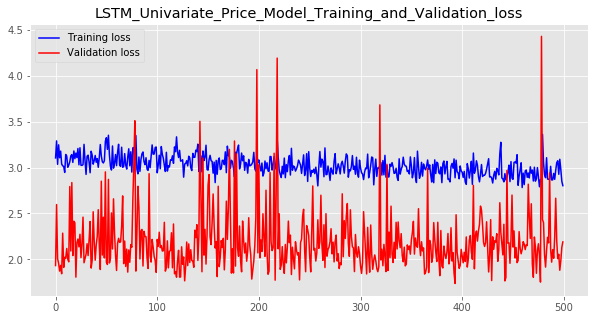

In [30]:
plot_train_history(LSTM_price_model_history, 'LSTM_Univariate_Price_Model_Training_and_Validation_loss')

## Predictions from LSTM Univariate

In [31]:
y_pred = LSTM_price_model.predict(x_test)
y_pred

array([[95.11812 ],
       [92.88379 ],
       [89.89645 ],
       [87.770546],
       [86.779945],
       [86.07177 ],
       [83.430695],
       [81.58105 ],
       [81.24894 ],
       [81.85889 ],
       [81.8232  ],
       [80.9447  ],
       [81.56545 ],
       [81.58299 ],
       [81.43795 ],
       [82.642006],
       [86.456924],
       [88.56332 ],
       [86.92493 ],
       [84.329185],
       [81.794235],
       [80.85692 ],
       [80.51936 ],
       [81.524   ],
       [81.23374 ],
       [84.11545 ],
       [86.03779 ],
       [87.35157 ],
       [87.789635]], dtype=float32)

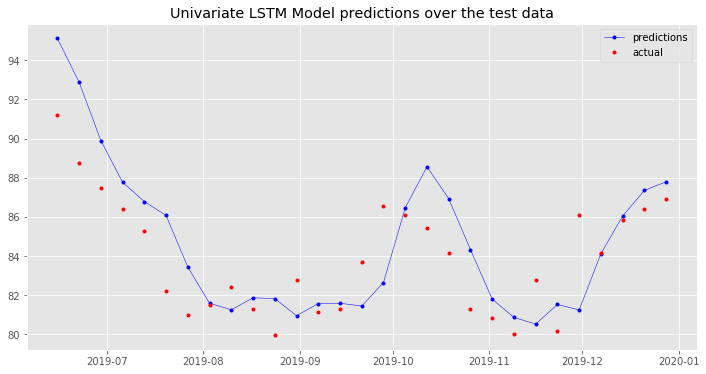

In [32]:
# Plot the predictions (one step ahead) against the test data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_test, 'r.', label='actual')
ax.set_title('Univariate LSTM Model predictions over the test data')
fig.savefig('../Images/UnivariateLSTMModelPredictions_testdata')
ax.legend();

In [33]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [34]:
# Calaculate MAPE
print(f'MAPE for known data (before 2020) = {mape(price_series, y_pred)}')

MAPE for known data (before 2020) = 11.11380067107362


## Try again with scaled data

In [35]:
# Data Loader Parameters
BATCH_SIZE = 32
BUFFER_SIZE = 10 # 
TRAIN_SPLIT = 300 # about 70%

# LSTM Parameters
EVALUATION_INTERVAL = 300
EPOCHS = 500
PATIENCE = 100

# Reproducibility
SEED = 13
# tf.random.set_seed(SEED)

n_prev = 10


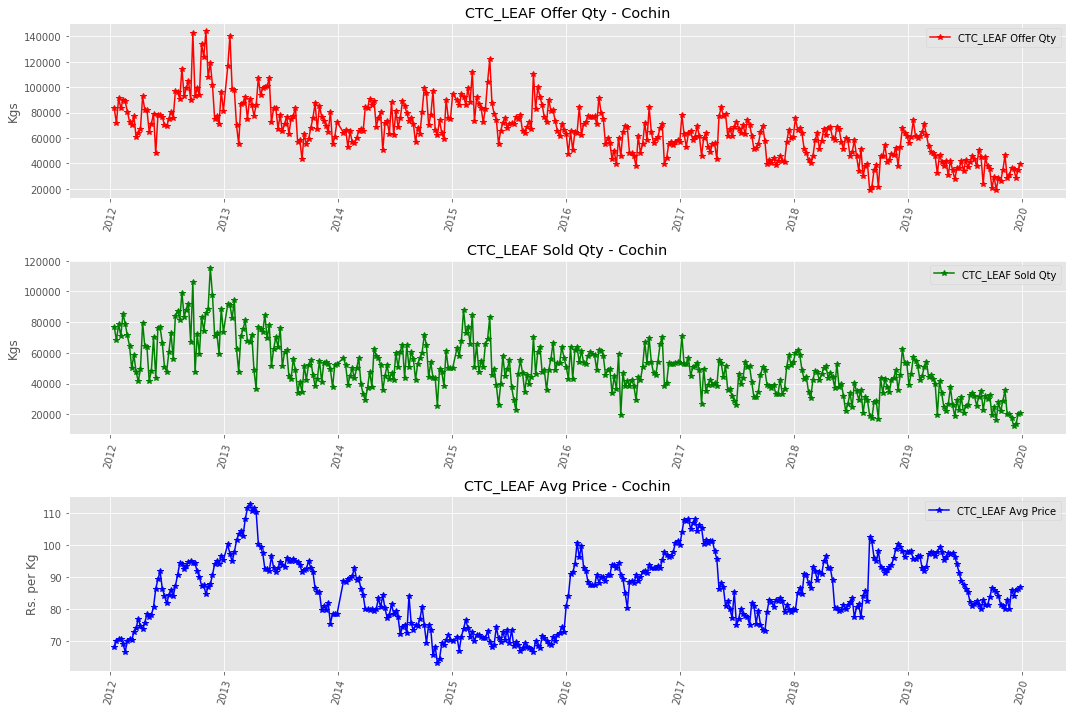

In [36]:
# Load the data again
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
# chop out 2020 data
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# Plot it
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')

In [37]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)


In [38]:
df_CHN_CTC_leaf.info()


<class 'pandas.core.frame.DataFrame'>
Index: 412 entries, 14-Jan-12 to 28-Dec-19
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                412 non-null    int64  
 1   serial_no           412 non-null    int64  
 2   ctc_leaf_offer_qty  412 non-null    float64
 3   ctc_leaf_sold_qty   412 non-null    float64
 4   ctc_leaf_avg_price  412 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.3+ KB


In [39]:
# Prepare the data for only the average price

In [40]:
uni_data = df_CHN_CTC_leaf['ctc_leaf_avg_price']
uni_data.index = df_CHN_CTC_leaf.index

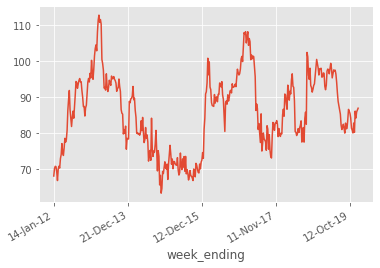

In [41]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [42]:
# Scale only the train data
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [43]:
# Create the data for the univariate model which will be given the last n_prev weeks' price observations, 
# and needs to learn to predict the temperature at the next week.
univariate_past_history = n_prev
univariate_future_target = 3

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [44]:
print("In:")
print(uni_data.shape)
print(uni_data[:5])

print("\nOut")
print(x_train_uni.shape)
print(y_train_uni[0])

print(x_train_uni.shape[0] / uni_data.shape[0])

In:
(412,)
[-1.44523537 -1.26413727 -1.21015611 -1.21886275 -1.3407557 ]

Out
(290, 10, 1)
-0.9472156014155011
0.7038834951456311


In [45]:
print ('Single window of past history. Shape: {}'.format(x_train_uni[0].shape))
print (x_train_uni[0])
print ('\n Target price to predict. Shape: {}'.format(y_train_uni[0].shape))
print (y_train_uni[0])

Single window of past history. Shape: (10, 1)
[[-1.44523537]
 [-1.26413727]
 [-1.21015611]
 [-1.21886275]
 [-1.3407557 ]
 [-1.55493902]
 [-1.28067989]
 [-1.20754412]
 [-1.25107731]
 [-1.02296336]]

 Target price to predict. Shape: ()
-0.9472156014155011


In [46]:
def create_time_steps(length):
    return list(range(-length, 0))

In [47]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
        plt.figsize = (18,6)
    
    return plt

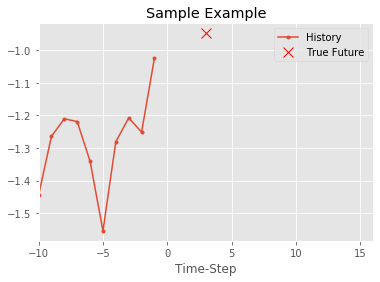

In [48]:
show_plot([x_train_uni[0], y_train_uni[0]], 3, 'Sample Example');

#### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [49]:
def baseline(history):
    return np.mean(history)

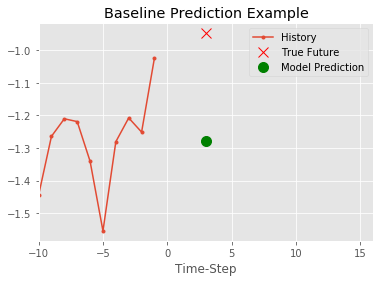

In [50]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 3,
           'Baseline Prediction Example');

In [51]:
# Let's now use tf.data to shuffle, batch, and cache the dataset.
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [52]:
x_train_uni.shape

(290, 10, 1)

In [53]:
# Set up the model
uni_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(32, input_shape=x_train_uni.shape[-2:], return_sequences=False),
    tf.keras.layers.Dense(1, activation='relu')
])

uni_lstm_model.compile(optimizer='adam', loss='mape')

In [54]:
# LSTM_price_model = keras.Sequential()
# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))
# LSTM_price_model.add(keras.layers.Dropout(0.1))
# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))
# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [55]:
for x, y in val_univariate.take(1):
    
    print(uni_lstm_model.predict(x).shape)

(32, 1)


In [56]:
tf.__version__

'2.3.0'

In [352]:
# train the univariate model
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
uni_lstm_model.fit(train_univariate,
                   epochs=EPOCHS,
                   steps_per_epoch=EVALUATION_INTERVAL,
                   validation_data=val_univariate,
                   callbacks=[early_stopping],
                   validation_steps=50)

Epoch 1/500
300/300 [==============================] - 3s 8ms/step - loss: 98.0867 - val_loss: 97.3833
Epoch 2/500
300/300 [==============================] - 2s 6ms/step - loss: 97.5319 - val_loss: 95.4811
Epoch 3/500
300/300 [==============================] - 2s 6ms/step - loss: 96.9064 - val_loss: 95.2732
Epoch 4/500
300/300 [==============================] - 2s 6ms/step - loss: 96.5752 - val_loss: 95.7874
Epoch 5/500
300/300 [==============================] - 2s 6ms/step - loss: 95.9546 - val_loss: 92.9024
Epoch 6/500
300/300 [==============================] - 2s 6ms/step - loss: 95.6076 - val_loss: 93.1107
Epoch 7/500
300/300 [==============================] - 2s 6ms/step - loss: 94.1001 - val_loss: 93.3120
Epoch 8/500
300/300 [==============================] - 2s 6ms/step - loss: 94.0497 - val_loss: 92.8486
Epoch 9/500
300/300 [==============================] - 2s 6ms/step - loss: 92.9271 - val_loss: 87.3781
Epoch 10/500
300/300 [==============================] - 2s 6ms/step - los

### Predict

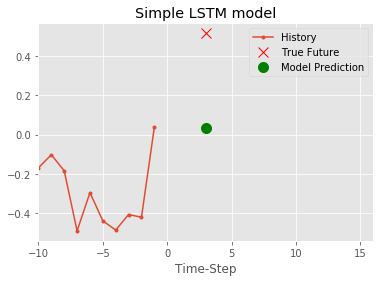

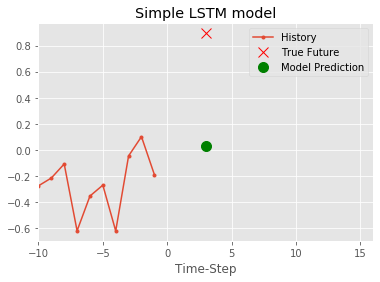

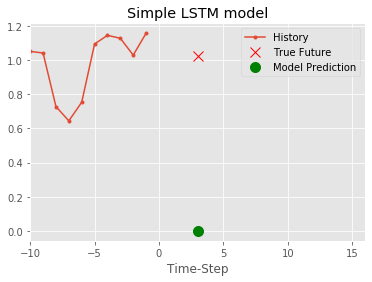

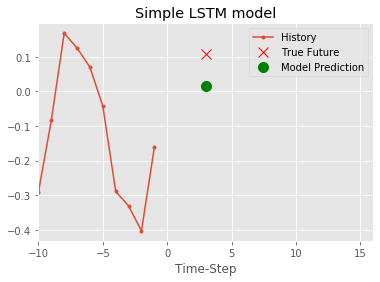

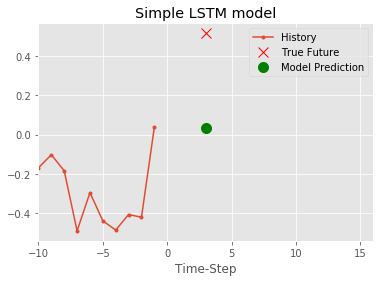

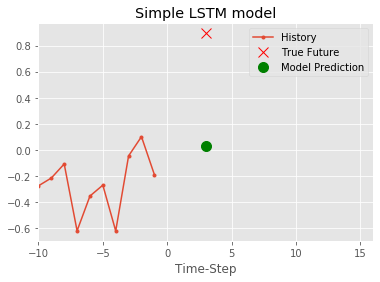

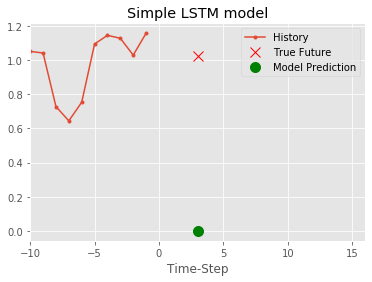

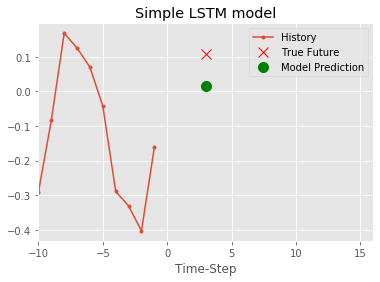

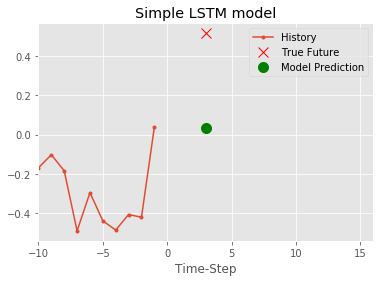

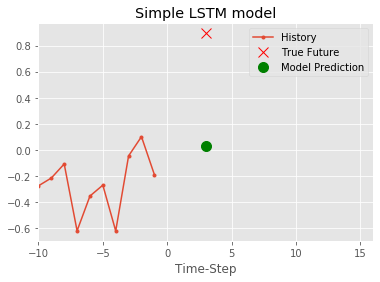

In [79]:
for x, y in val_univariate.take(10):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    uni_lstm_model.predict(x)[0]], 3, 'Simple LSTM model')
    plot.show()

#### Poor results for univariate!

## Multivariate

In [80]:
# Data Loader Parameters
BATCH_SIZE = 32
BUFFER_SIZE = 10 # 10000
TRAIN_SPLIT = 300 # ~ 70:30 300K out of 420K

# Reproducibility
SEED = 13
# tf.random.set_seed(SEED)

n_prev = 10


First for 3 features from the same tea category (CTC Leaf): ctc_leaf_avg_price, ctc_leaf_offer_qty & ctc_leaf_sold_qty.

In [81]:
features_considered = ['ctc_leaf_offer_qty', 'ctc_leaf_sold_qty', 'ctc_leaf_avg_price']

In [82]:
features = df_CHN_CTC_leaf[features_considered]
features.index = df_CHN_CTC_leaf.index
features.head()

,ctc_leaf_offer_qty,ctc_leaf_sold_qty,ctc_leaf_avg_price
week_ending,,,
14-Jan-12,83325.0,77015.0,68.03
21-Jan-12,71897.0,68187.0,70.11
28-Jan-12,91279.0,78695.0,70.73
4-Feb-12,83746.0,71188.0,70.63
11-Feb-12,89650.0,85480.0,69.23


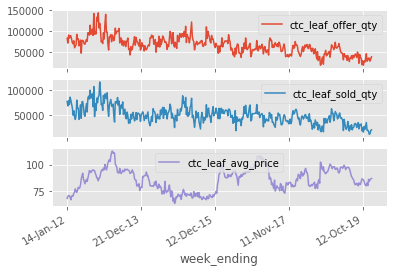

In [83]:
features.plot(subplots=True)
plt.savefig('../Images/AllFeatures')

Standardize the training dataset using the mean and standard deviation of the training data.

In [84]:
TRAIN_SPLIT

300

In [85]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#dataset = (dataset-data_mean)/data_std

In [86]:
pd.DataFrame(dataset, columns = features.columns, index= features.index).head()

,ctc_leaf_offer_qty,ctc_leaf_sold_qty,ctc_leaf_avg_price
week_ending,,,
14-Jan-12,83325.0,77015.0,68.03
21-Jan-12,71897.0,68187.0,70.11
28-Jan-12,91279.0,78695.0,70.73
4-Feb-12,83746.0,71188.0,70.63
11-Feb-12,89650.0,85480.0,69.23


#### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the windowing task as below, however, here it samples the past observation based on the step size given.

In [87]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

The model is shown data from the last n_prev weeks.
For the single step prediction model, the label for a datapoint is the price 1 weeks into the future. 

In [88]:
past_history = n_prev # 10 weeks
future_target = 3 # after 3 weeks
STEP = 1 # take consecutive observations, no skips

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 2],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.

In [89]:
print(x_train_single.shape)
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])
y_train_single.shape

(290, 10, 3)
Single window of past history : (10, 3)
(10, 3)


(290,)

In [90]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### Setup Multivariate Model -Single output

In [73]:
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:], return_sequences=True))

single_step_model.add(keras.layers.Dropout(0.1))

single_step_model.add(keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:], return_sequences=False))

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mape')

Let's check out a sample prediction.

In [74]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(32, 1)


In [75]:
# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 300
PATIENCE = 300

In [76]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=50)

Evaluation Threshold: 200
Epochs: 300
Epoch 1/300
200/200 [==============================] - 2s 9ms/step - loss: 89.2298 - val_loss: 84.9521
Epoch 2/300
200/200 [==============================] - 1s 6ms/step - loss: 80.0682 - val_loss: 77.5693
Epoch 3/300
200/200 [==============================] - 1s 6ms/step - loss: 72.2248 - val_loss: 70.2055
Epoch 4/300
200/200 [==============================] - 1s 6ms/step - loss: 64.3879 - val_loss: 62.8486
Epoch 5/300
200/200 [==============================] - 1s 6ms/step - loss: 56.5501 - val_loss: 55.4898
Epoch 6/300
200/200 [==============================] - 1s 6ms/step - loss: 48.7146 - val_loss: 48.1366
Epoch 7/300
200/200 [==============================] - 1s 6ms/step - loss: 40.8771 - val_loss: 40.7723
Epoch 8/300
200/200 [==============================] - 1s 6ms/step - loss: 33.0398 - val_loss: 33.4155
Epoch 9/300
200/200 [==============================] - 1s 6ms/step - loss: 25.2116 - val_loss: 26.0578
Epoch 10/300
200/200 [=============

200/200 [==============================] - 1s 6ms/step - loss: 5.2626 - val_loss: 7.1027
Epoch 81/300
200/200 [==============================] - 1s 6ms/step - loss: 5.2067 - val_loss: 6.5630
Epoch 82/300
200/200 [==============================] - 1s 6ms/step - loss: 5.2430 - val_loss: 7.0348
Epoch 83/300
200/200 [==============================] - 1s 6ms/step - loss: 5.1995 - val_loss: 7.0165
Epoch 84/300
200/200 [==============================] - 1s 6ms/step - loss: 5.1082 - val_loss: 6.7235
Epoch 85/300
200/200 [==============================] - 1s 6ms/step - loss: 5.0756 - val_loss: 6.5653
Epoch 86/300
200/200 [==============================] - 1s 6ms/step - loss: 5.0961 - val_loss: 7.1375
Epoch 87/300
200/200 [==============================] - 1s 6ms/step - loss: 5.0026 - val_loss: 6.9034
Epoch 88/300
200/200 [==============================] - 1s 6ms/step - loss: 5.0742 - val_loss: 7.3041
Epoch 89/300
200/200 [==============================] - 1s 6ms/step - loss: 4.9971 - val_loss: 

Epoch 160/300
200/200 [==============================] - 1s 6ms/step - loss: 3.4339 - val_loss: 7.9382
Epoch 161/300
200/200 [==============================] - 1s 6ms/step - loss: 3.4287 - val_loss: 8.1119
Epoch 162/300
200/200 [==============================] - 1s 6ms/step - loss: 3.4324 - val_loss: 7.8232
Epoch 163/300
200/200 [==============================] - 1s 6ms/step - loss: 3.4029 - val_loss: 8.0682
Epoch 164/300
200/200 [==============================] - 1s 6ms/step - loss: 3.3691 - val_loss: 7.9466
Epoch 165/300
200/200 [==============================] - 1s 6ms/step - loss: 3.4315 - val_loss: 7.9585
Epoch 166/300
200/200 [==============================] - 1s 6ms/step - loss: 3.3608 - val_loss: 8.2486
Epoch 167/300
200/200 [==============================] - 1s 6ms/step - loss: 3.3749 - val_loss: 7.9159
Epoch 168/300
200/200 [==============================] - 1s 6ms/step - loss: 3.3053 - val_loss: 8.2290
Epoch 169/300
200/200 [==============================] - 1s 6ms/step - lo

200/200 [==============================] - 1s 6ms/step - loss: 2.8035 - val_loss: 8.2630
Epoch 240/300
200/200 [==============================] - 1s 6ms/step - loss: 2.8232 - val_loss: 7.9642
Epoch 241/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7927 - val_loss: 8.2944
Epoch 242/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7664 - val_loss: 8.1984
Epoch 243/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7587 - val_loss: 8.3335
Epoch 244/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7255 - val_loss: 7.7502
Epoch 245/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7386 - val_loss: 7.8322
Epoch 246/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7157 - val_loss: 8.6108
Epoch 247/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7520 - val_loss: 7.7862
Epoch 248/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7393 - v

In [91]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.savefig('../Images/' + title + '.png')
    plt.show()

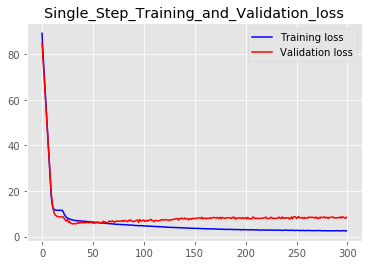

In [92]:
plot_train_history(single_step_history,
                   'Single_Step_Training_and_Validation_loss')


#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past n_prev weeks, and is to predict the price 3 weeks into the future. The plot only displays the past prices. Since the prediction is made 3 weeks into the future, there is a gap between the history and prediction).

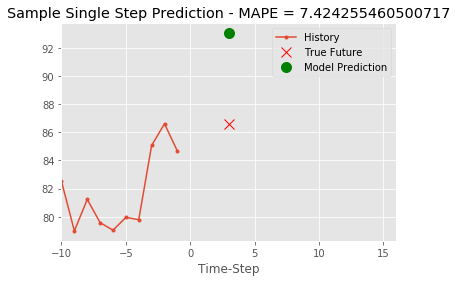

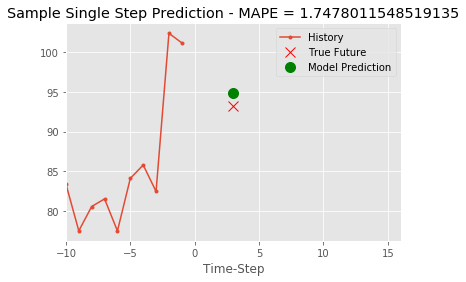

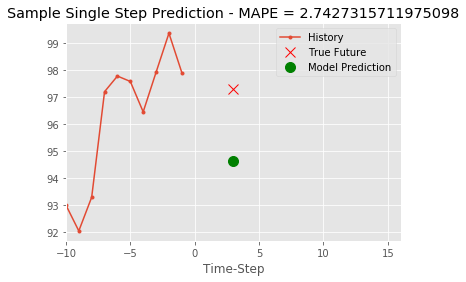

In [140]:
i = 1
for x, y in val_data_single.take(3):
    plot = show_plot([x[2][:, 2].numpy(), y[2].numpy(),
                    single_step_model.predict(x)[2]], 3,
                   'Single Step Prediction')
    plt.title(f'Sample Single Step Prediction - MAPE = {mape(y[2].numpy(), single_step_model.predict(x)[2] )}')
    plt.savefig('../Images/SampleSingeStepPredictions' + str(i))
    i += 1
    plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of prices over the past n_prev weeks. However, here, the model needs to learn to predict the prices for the next 3 weeks. The output is 3 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [106]:
past_history = n_prev # 10 weeks 
future_target = 3 # after 3 weeks 
STEP = 3 # no gap between last observation and first prediction

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [107]:
print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[2].shape),
       'Target temperature to predict : {}'.format(y_train_multi[2].shape),
       sep='\n')

(290, 4, 3)
(290, 3)
Single window of past history : (4, 3)
Target temperature to predict : (3,)


In [108]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [135]:
def multi_step_plot(history, true_future, prediction, sample_number=''):
    plt.figure(figsize=(15, 4))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 2]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.title(f'Multi Step Prediction - MAPE = {mape(true_future, prediction)}')
    plt.savefig('../Images/SampleMultiStepPredictions' + sample_number)
    plt.show()

In [111]:
# for x, y in train_data_multi.take(1):
#     multi_step_plot(x[2], y[2], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 3 predictions are made, the dense layer outputs 3 predictions.

### Setup Multivariate Model -Multiple steps output

In [104]:
multi_step_model = tf.keras.models.Sequential()

multi_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:], return_sequences=True))

multi_step_model.add(keras.layers.Dropout(0.1))

multi_step_model.add(keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:], return_sequences=False))

multi_step_model.add(tf.keras.layers.Dense(3))

# multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mape')
multi_step_model.compile(optimizer='adam', loss='mape')

print(multi_step_model.summary())



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 32)            4608      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 13,027
Trainable params: 13,027
Non-trainable params: 0
_________________________________________________________________
None


Let's see how the model predicts before it trains.

In [105]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(32, 3)


In [113]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 100, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/300
200/200 [==============================] - 1s 7ms/step - loss: 92.5564 - val_loss: 86.6668
Epoch 2/300
200/200 [==============================] - 1s 5ms/step - loss: 81.2959 - val_loss: 78.2790
Epoch 3/300
200/200 [==============================] - 1s 5ms/step - loss: 72.7105 - val_loss: 70.4276
Epoch 4/300
200/200 [==============================] - 1s 5ms/step - loss: 64.4567 - val_loss: 62.7638
Epoch 5/300
200/200 [==============================] - 1s 5ms/step - loss: 56.3536 - val_loss: 55.1968
Epoch 6/300
200/200 [==============================] - 1s 5ms/step - loss: 48.3174 - val_loss: 47.6793
Epoch 7/300
200/200 [==============================] - 1s 5ms/step - loss: 40.3359 - val_loss: 40.2029
Epoch 8/300
200/200 [==============================] - 1s 4ms/step - loss: 32.3852 - val_loss: 32.7436
Epoch 9/300
200/200 [==============================] - 1s 5ms/step - loss: 24.4755 - val_loss: 25.3563
Epoch 10/300
200/200 [==============================] - 1s 5ms/step - los

Epoch 74/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3473 - val_loss: 8.5799
Epoch 75/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3472 - val_loss: 8.4886
Epoch 76/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3466 - val_loss: 8.4827
Epoch 77/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3371 - val_loss: 8.4048
Epoch 78/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3452 - val_loss: 8.6059
Epoch 79/300
200/200 [==============================] - 1s 5ms/step - loss: 11.3324 - val_loss: 8.5361
Epoch 80/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3381 - val_loss: 8.5112
Epoch 81/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3266 - val_loss: 8.4739
Epoch 82/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3308 - val_loss: 8.5538
Epoch 83/300
200/200 [==============================] - 1s 4ms/step - los

200/200 [==============================] - 1s 4ms/step - loss: 11.3100 - val_loss: 8.5506
Epoch 154/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3334 - val_loss: 8.5827
Epoch 155/300
200/200 [==============================] - 1s 5ms/step - loss: 11.3343 - val_loss: 8.6693
Epoch 156/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3118 - val_loss: 8.5635
Epoch 157/300
200/200 [==============================] - 1s 5ms/step - loss: 11.3312 - val_loss: 8.4632
Epoch 158/300
200/200 [==============================] - 1s 5ms/step - loss: 11.3298 - val_loss: 8.5107
Epoch 159/300
200/200 [==============================] - 1s 5ms/step - loss: 11.3227 - val_loss: 8.5598
Epoch 160/300
200/200 [==============================] - 1s 4ms/step - loss: 11.3458 - val_loss: 8.5448
Epoch 161/300
200/200 [==============================] - 1s 5ms/step - loss: 11.3153 - val_loss: 8.5551
Epoch 162/300
200/200 [==============================] - 1s 5ms/step - loss: 1

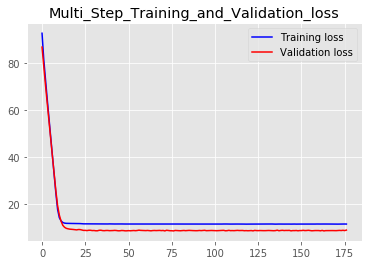

In [114]:
plot_train_history(multi_step_history, 'Multi_Step_Training_and_Validation_loss')

Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

In [120]:
multi_step_model.predict(x)[0]

array([82.96099 , 83.138405, 83.54748 ], dtype=float32)

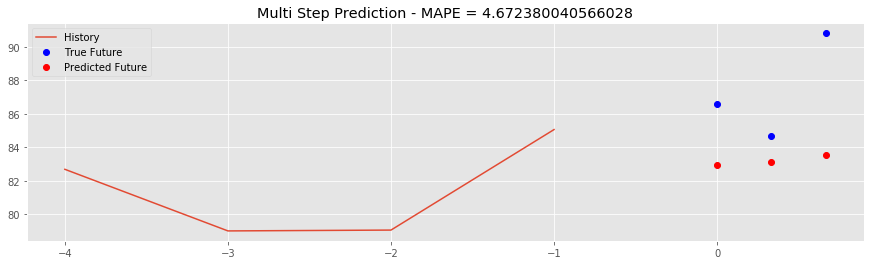

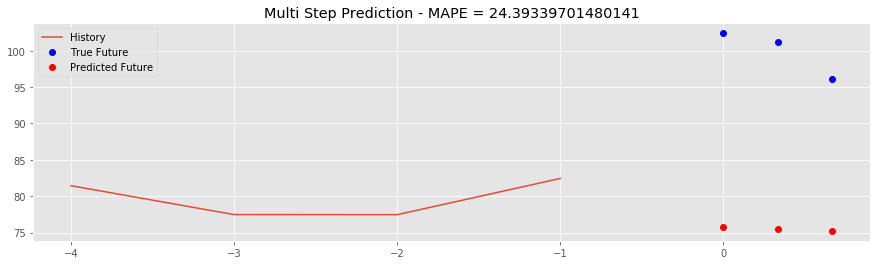

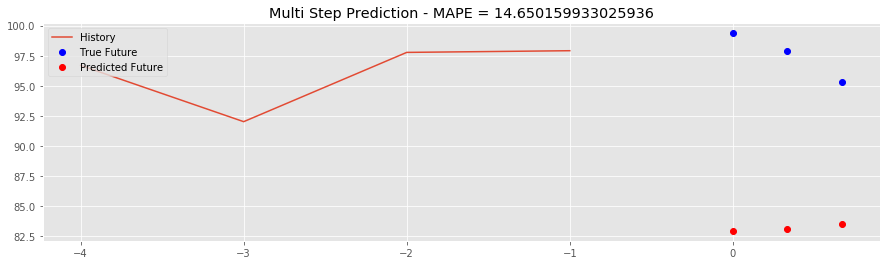

In [136]:
i = 1
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], str(i))
    i += 1
#     print(f'MAPE = {mape(y[0], multi_step_model.predict(x)[0])}')

In [133]:
print(f'MAPE = {mape(y[0], multi_step_model.predict(x)[0])}')
#mape(y[0], multi_step_model.predict(x)[0])

MAPE = 13.543099164962769


### Multi-Step, Multi-Input, and Multi-Output

In [128]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [174]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns[:3], ['r', 'b', 'g'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [130]:
future_target = 3
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [131]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target price to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(290, 10, 2, 1, 1)
(290, 3, 2, 1, 1)
(99, 10, 2, 1, 1)
(99, 3, 2, 1, 1)
Single window of past history : (10, 2, 1, 1)
Target price to predict : (3, 2, 1, 1)


In [132]:
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

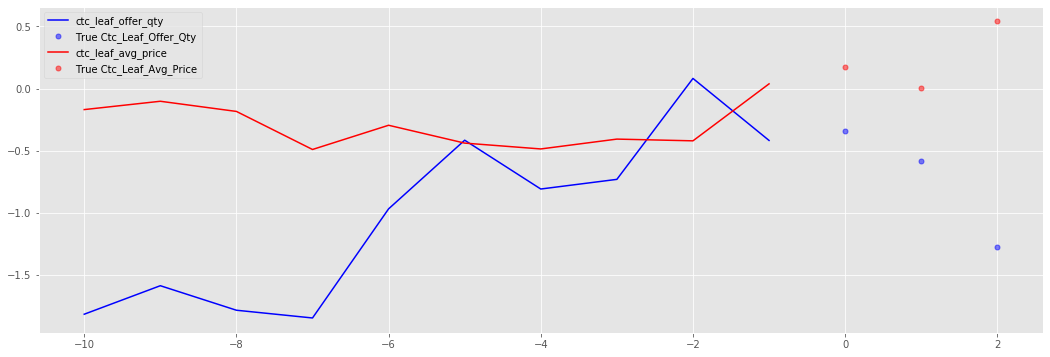

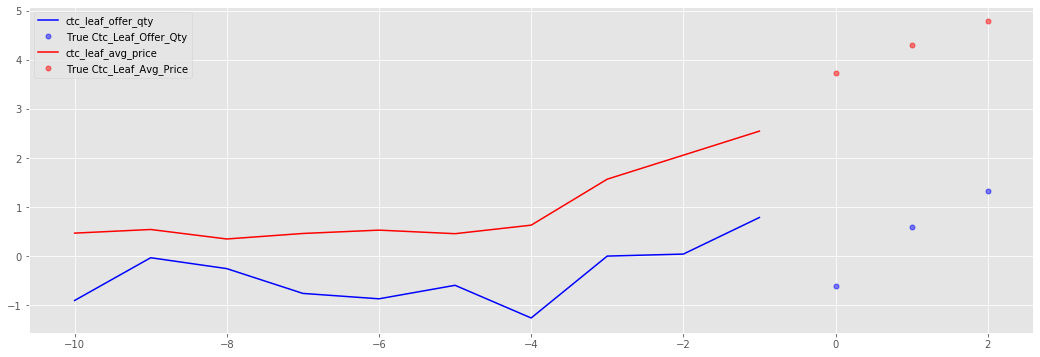

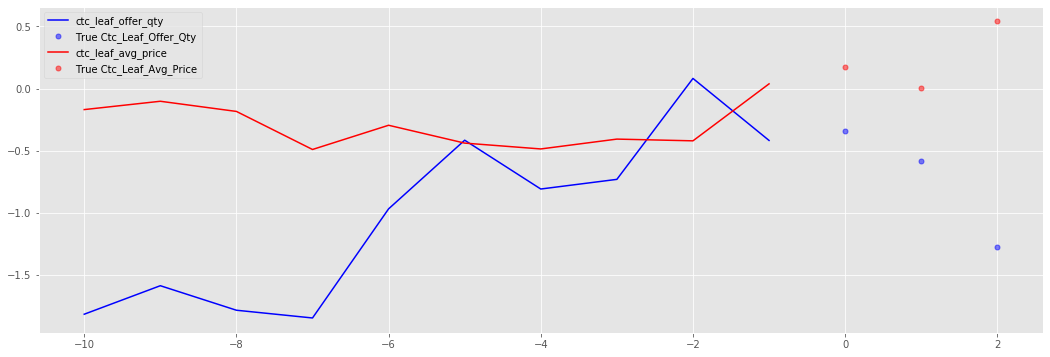

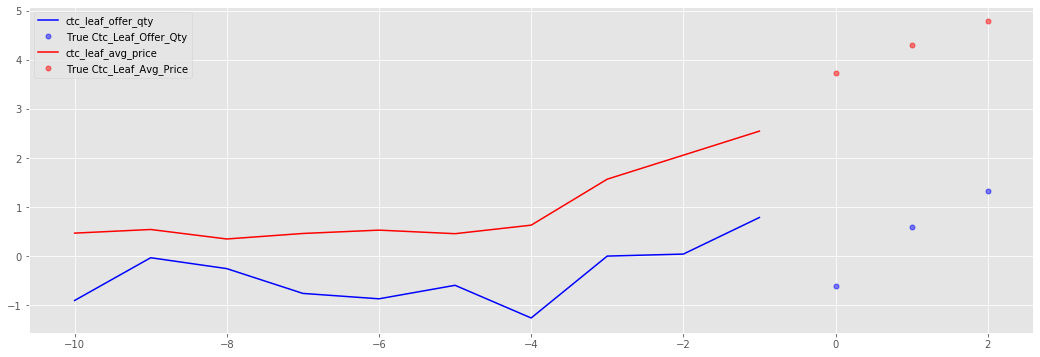

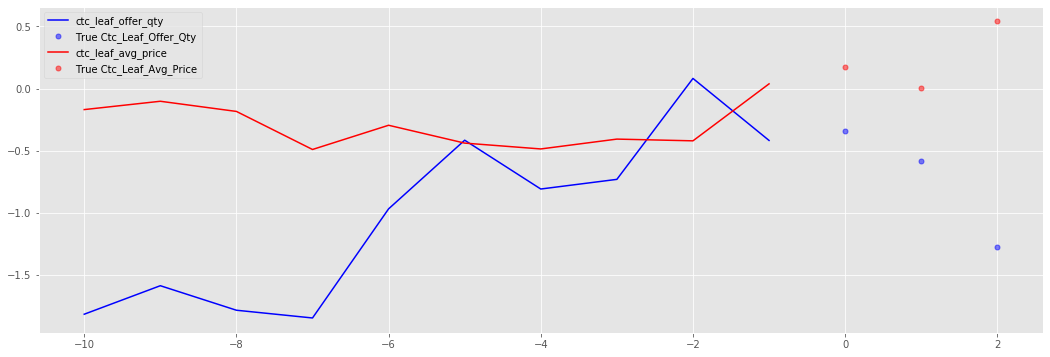

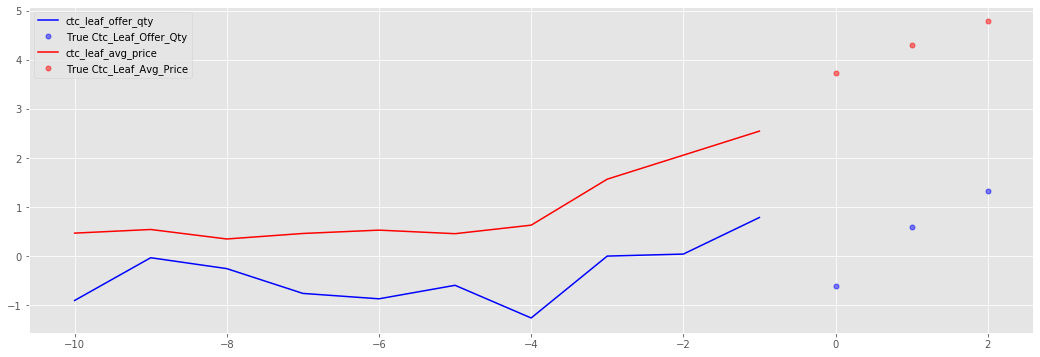

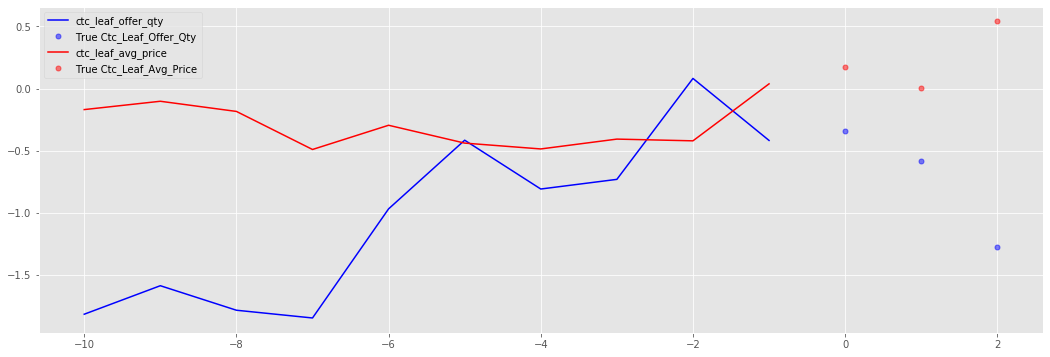

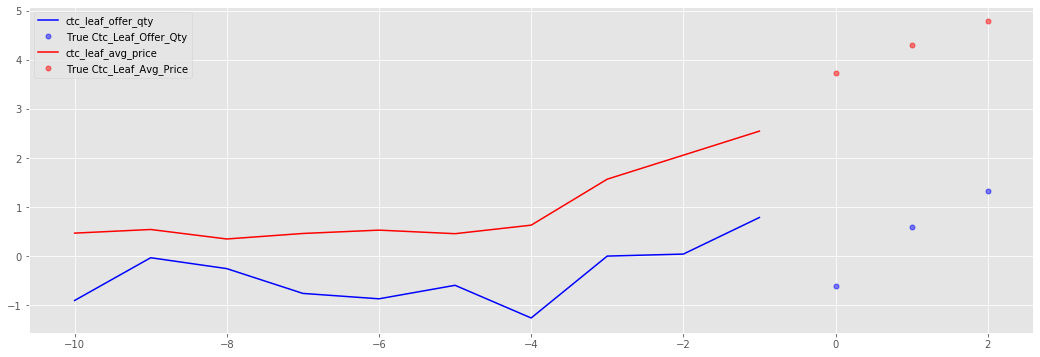

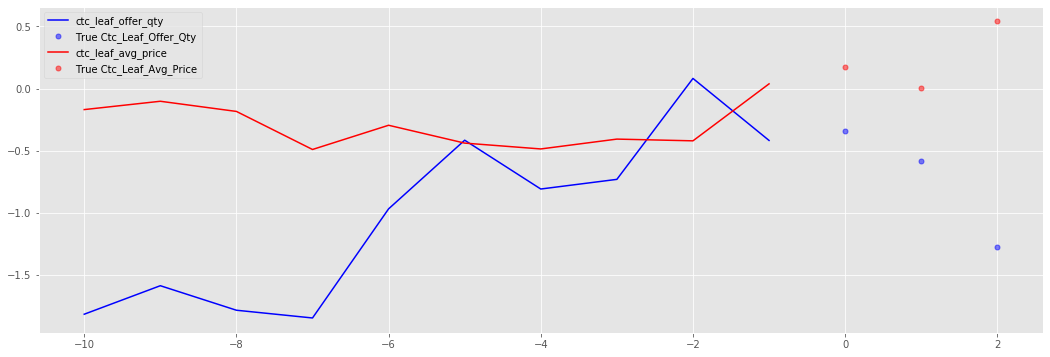

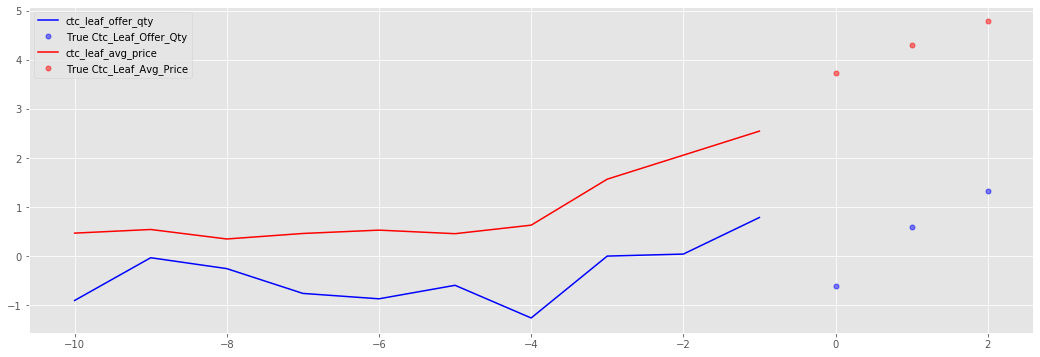

In [112]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

Convolutional LSTM
As taken from the paper.

In [133]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    # COPY PASTE
    # https://github.com/niklascp/bus-arrival-convlstm/blob/master/jupyter/ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.ipynb
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mape", optimizer = optimizer, metrics = ['mape', 'mse'])
    return model

In [182]:
future_target = 3
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:3], dataset[:,:3], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:3], dataset[:, :3],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [185]:
# x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2]
x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2]

(10, 3, 3, 3)

In [186]:
## import time
EPOCHS = 40
steps_per_epoch = 290
validation_steps = 135

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 10, 3, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 3, 1, 64)          166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 1, 64)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 3, 1, 64)          256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 192)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 3, 192)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 3, 3, 1, 64)     

In [187]:
# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))


TRAIN MODEL...
Epoch 1/40
290/290 [==============================] - 7s 25ms/step - loss: 81.5470 - mape: 81.5470 - mae: 42783.5859 - mse: 2999654656.0000 - val_loss: 70.6995 - val_mape: 70.6997 - val_mae: 27082.2773 - val_mse: 1221886464.0000
Epoch 2/40
290/290 [==============================] - 7s 24ms/step - loss: 70.6348 - mape: 70.6348 - mae: 42761.7266 - mse: 2998520064.0000 - val_loss: 69.5311 - val_mape: 69.5313 - val_mae: 27069.8926 - val_mse: 1221095808.0000
Epoch 3/40
290/290 [==============================] - 7s 24ms/step - loss: 69.1192 - mape: 69.1193 - mae: 42711.7773 - mse: 2991830784.0000 - val_loss: 69.3202 - val_mape: 69.3204 - val_mae: 27059.5664 - val_mse: 1220246400.0000
Epoch 4/40
290/290 [==============================] - 7s 24ms/step - loss: 68.0987 - mape: 68.0987 - mae: 42733.9375 - mse: 2995008512.0000 - val_loss: 68.8821 - val_mape: 68.8822 - val_mae: 27057.6562 - val_mse: 1220111872.0000
Epoch 5/40
290/290 [==============================] - 7s 24ms/step -

Epoch 37/40
290/290 [==============================] - 7s 24ms/step - loss: 66.6744 - mape: 66.6744 - mae: 42714.5117 - mse: 2992578816.0000 - val_loss: 68.9476 - val_mape: 68.9478 - val_mae: 27032.5840 - val_mse: 1218005632.0000
Epoch 38/40
290/290 [==============================] - 7s 24ms/step - loss: 66.6725 - mape: 66.6725 - mae: 42713.0625 - mse: 2992636672.0000 - val_loss: 68.9803 - val_mape: 68.9802 - val_mae: 27032.2715 - val_mse: 1217969920.0000
Epoch 39/40
290/290 [==============================] - 7s 24ms/step - loss: 66.6709 - mape: 66.6709 - mae: 42684.5742 - mse: 2988444672.0000 - val_loss: 68.9197 - val_mape: 68.9197 - val_mae: 27031.7227 - val_mse: 1217929344.0000
Epoch 40/40
290/290 [==============================] - 7s 24ms/step - loss: 66.6704 - mape: 66.6705 - mae: 42714.5508 - mse: 2992568320.0000 - val_loss: 68.8490 - val_mape: 68.8489 - val_mae: 27031.6973 - val_mse: 1217931904.0000

Model Runtime: 4.85 Minutes


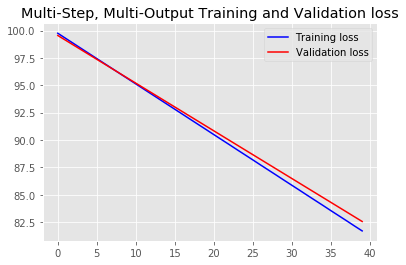

In [171]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and Validation loss')

In [172]:
np.squeeze(x[1])

array([[45759.  , 42407.  ,    83.45],
       [42226.  , 33261.  ,    82.51],
       [41110.  , 36443.  ,    78.99],
       [56832.  , 50941.  ,    81.23],
       [66725.  , 58765.  ,    79.58],
       [59692.  , 52098.  ,    79.04],
       [61083.  , 53934.67,    79.95],
       [75627.  , 59686.  ,    79.79],
       [66691.  , 61675.  ,    85.06],
       [68023.  , 58585.  ,    86.6 ]])

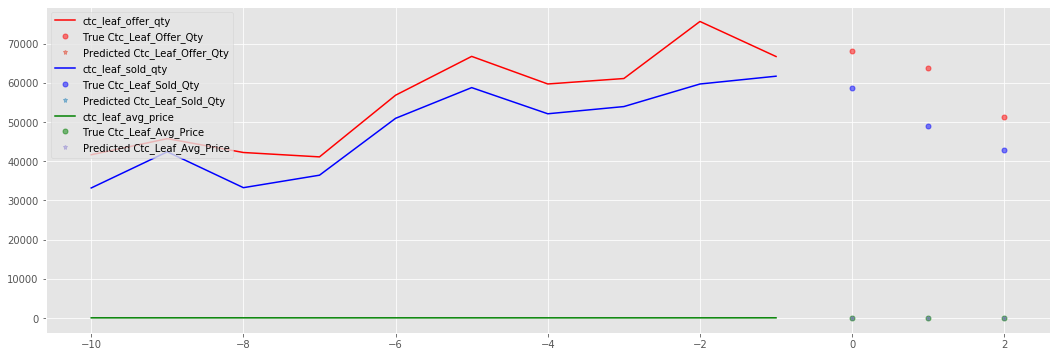

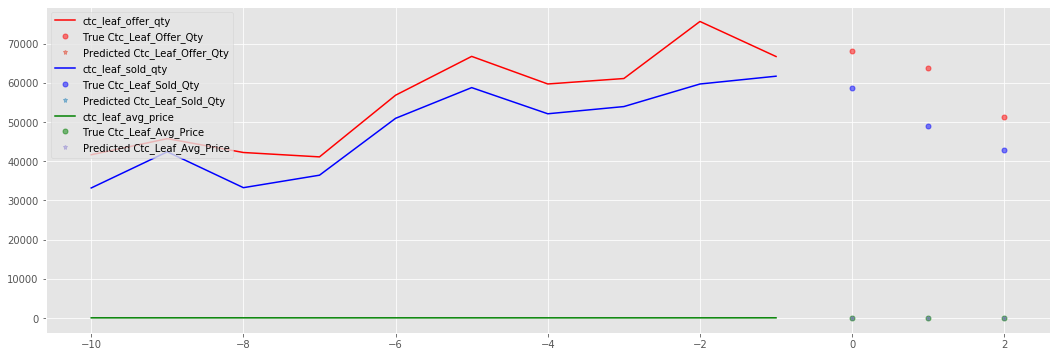

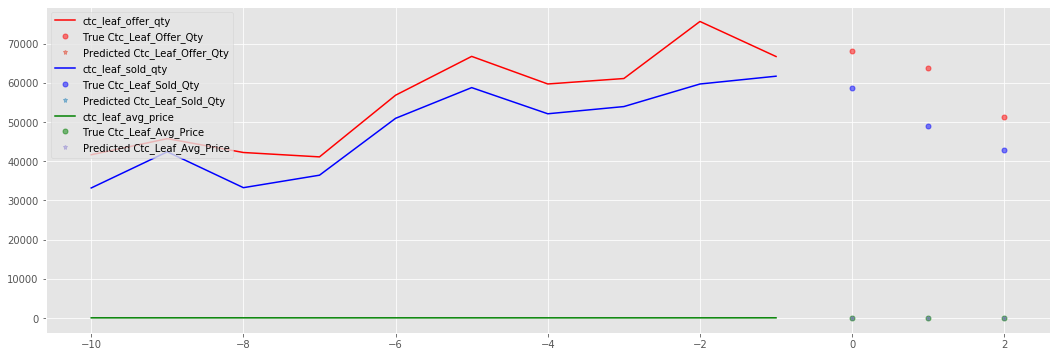

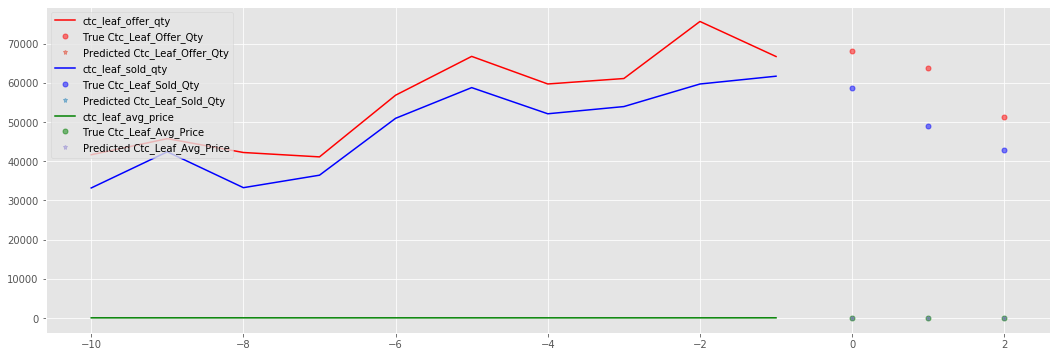

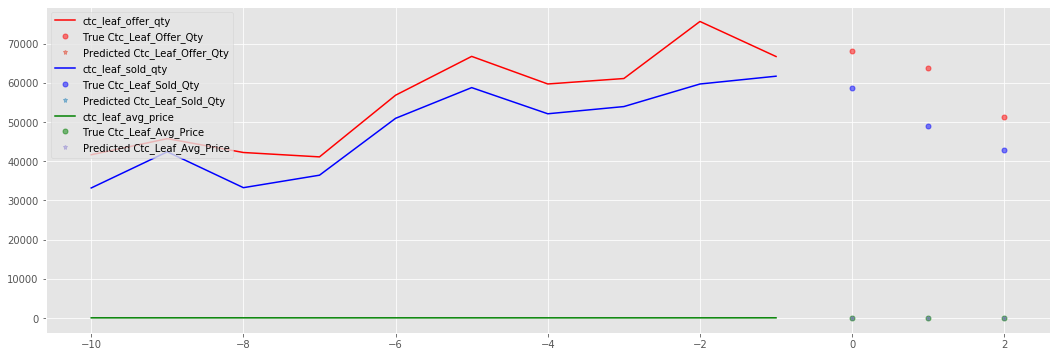

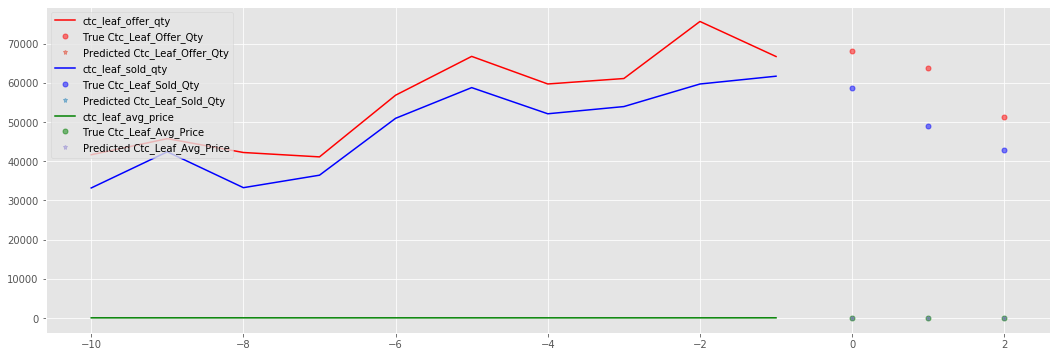

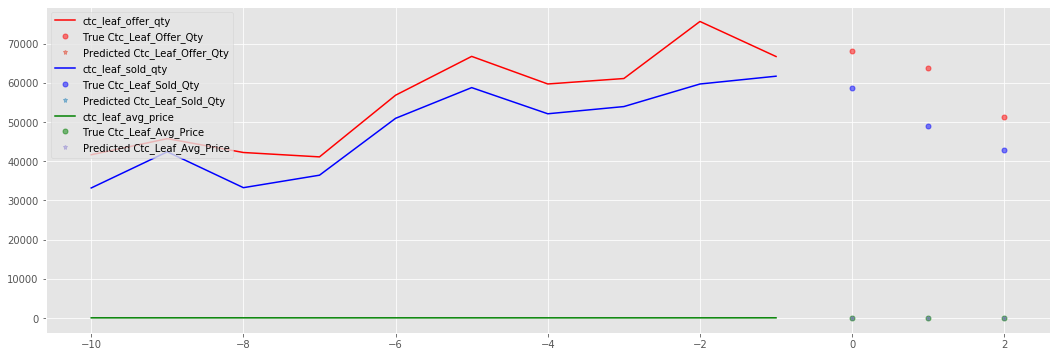

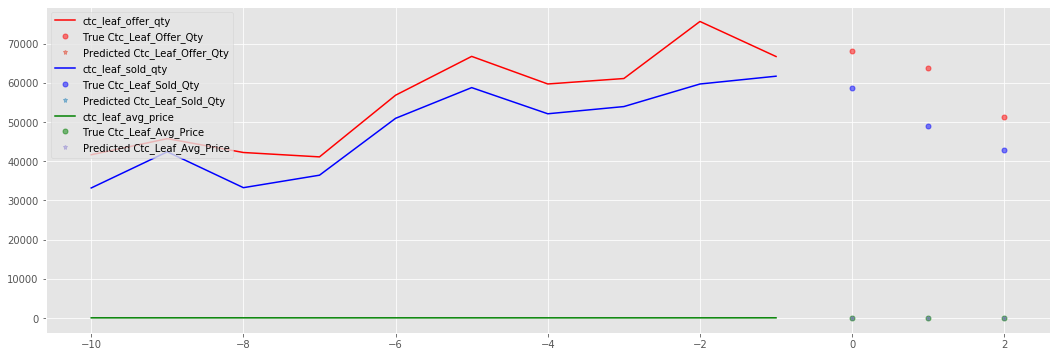

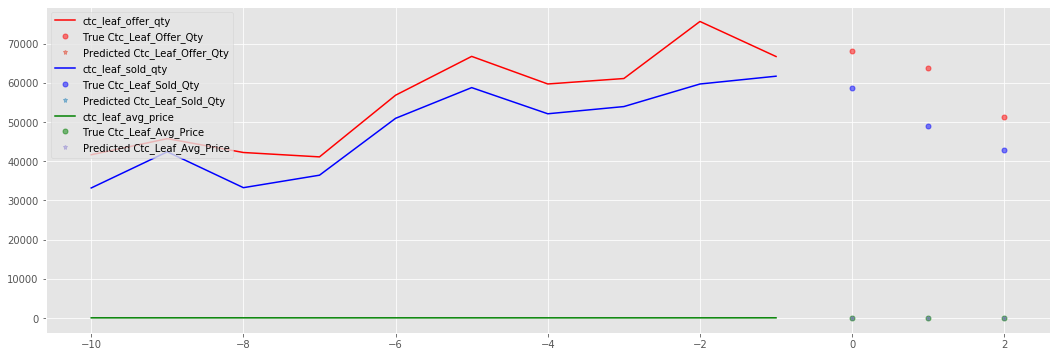

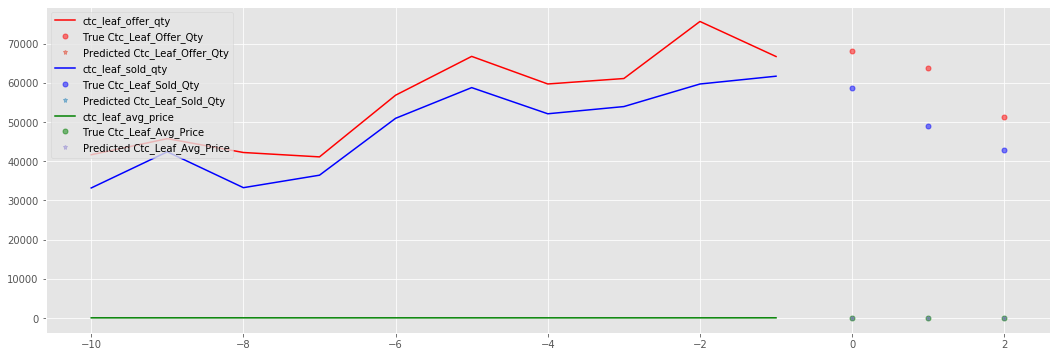

In [175]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

#### Now simplifying the Convolutional LSTM

In [176]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.1, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

#     model.add(ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (5, 1), 
#                          padding='same',
#                          return_sequences = False))
    
#     model.add(Dropout(0.20, name = 'dropout_2'))
#     model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
#     model.add(ConvLSTM2D(name ='conv_lstm_3',
#                          filters = 64, kernel_size = (10, 1), 
#                          padding='same',
#                          return_sequences = True))
    
#     model.add(Dropout(0.20, name = 'dropout_3'))
#     model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mape", optimizer = optimizer, metrics = ['mape', 'mae', 'mse'])
    return model

In [177]:
# Extend Prediction Window..
future_target = 6
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:3], dataset[:,:3], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:3], dataset[:, :3],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [179]:
x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2]

(10, 6, 2, 2)

In [178]:
EPOCHS = 30
steps_per_epoch = 290
validation_steps = 290

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 10, 2, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 2, 1, 64)          166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 2, 1, 64)          256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 128)            0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 6, 2, 1, 64)      

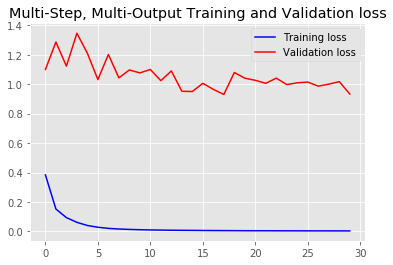

In [161]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and Validation loss')

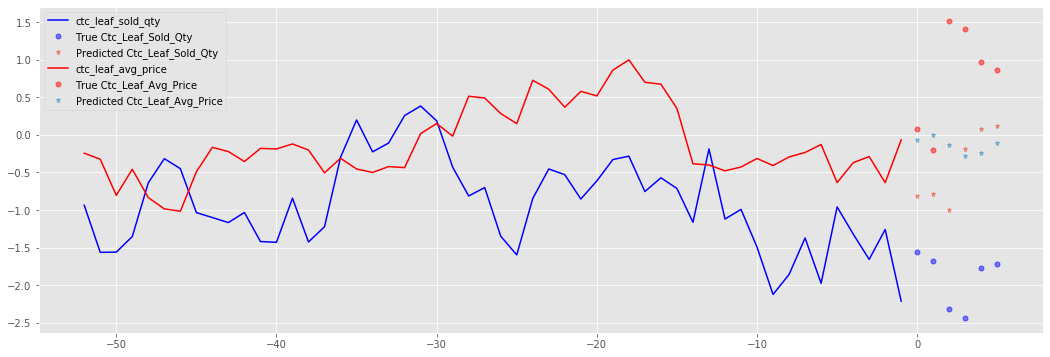

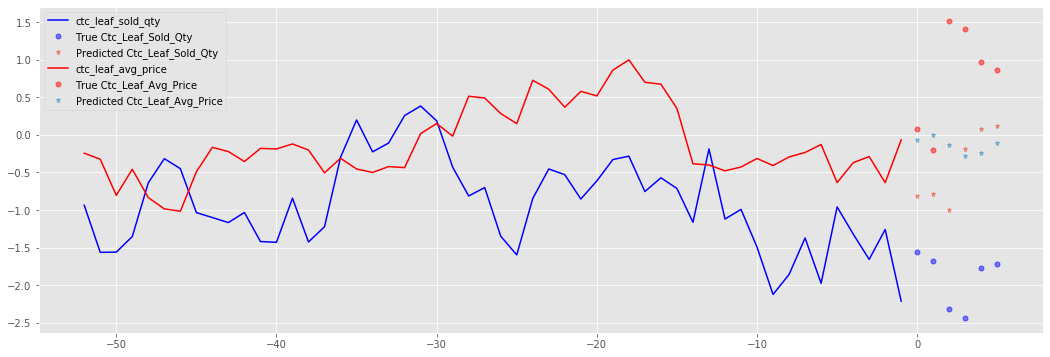

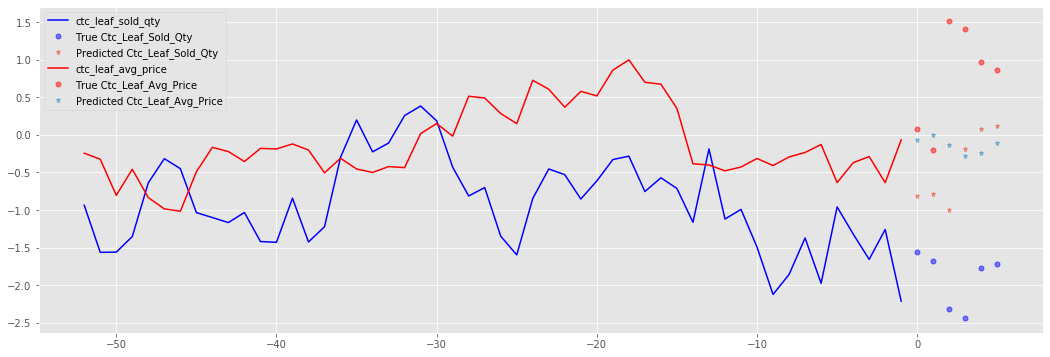

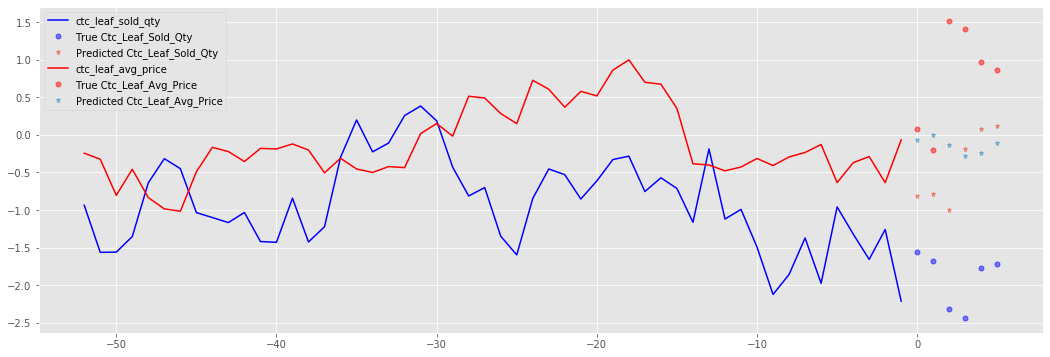

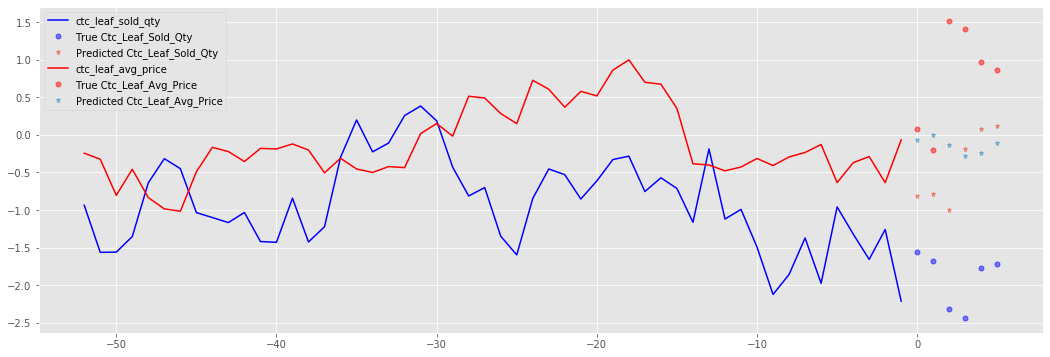

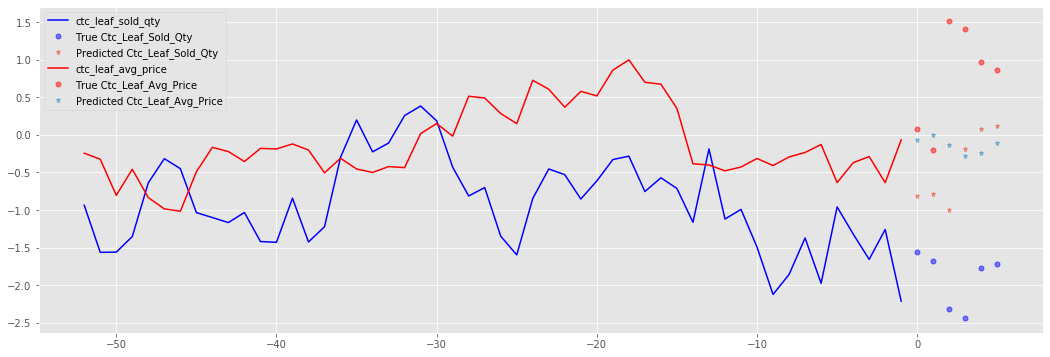

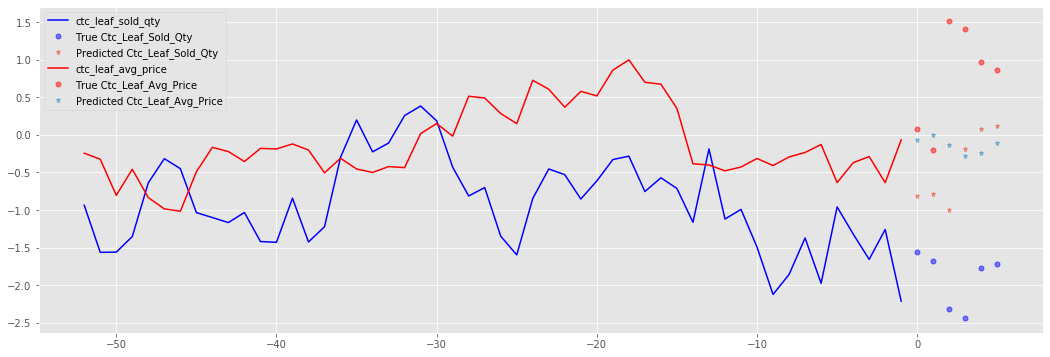

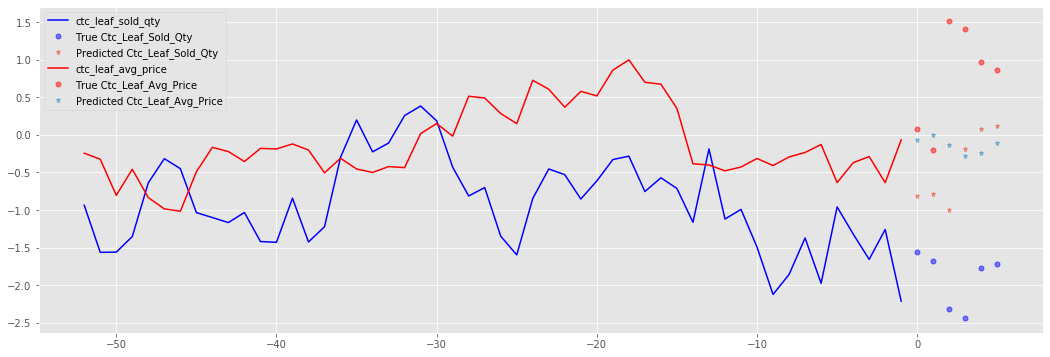

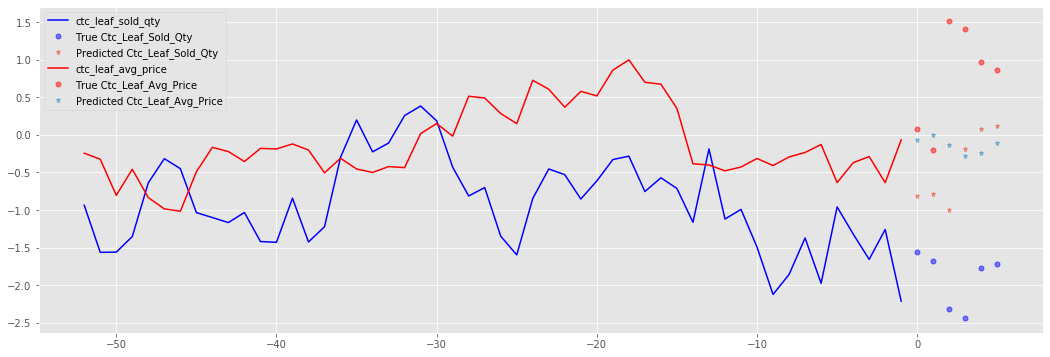

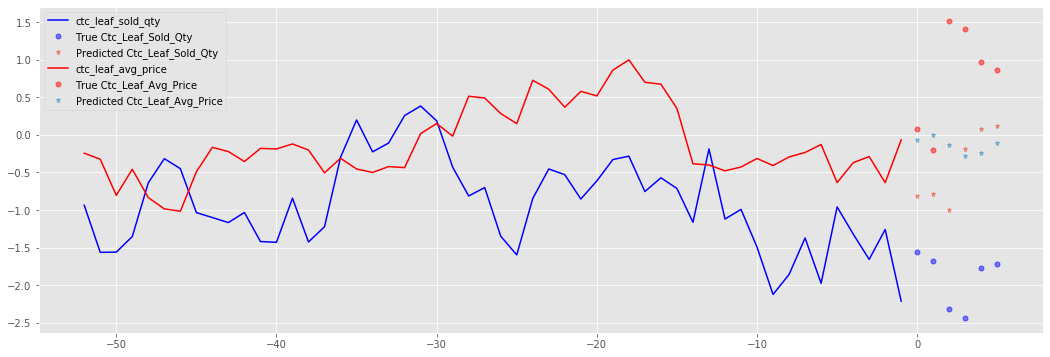

In [162]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

### TBDs

- Fix ConvolutionalLSTM model above
- Try data upto end September 2020 in above models